# W207 Final Project - Facial Keypoint Recognition 
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

In [107]:
# dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

import time
import os.path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import cv2
from random import randrange
from math import sin, cos, pi
%matplotlib inline

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras import optimizers, Input, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2


np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.8.0


### Load Data 

In [10]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


In [11]:
# load data
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


In [13]:
# helper functions for data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [14]:
# transform all data
X = np.array([two_dim(train.Image[i]) for i in range(len(train))])

X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
print(f'Train examples {numTrainExamples}')
print(f'Train features {numFeatures}')
print(f'mini_Train examples {numMiniExamples}')
print(f'Dev examples {numDevExamples}')


Train examples 5000
Train features 9216
mini_Train examples 1000
Dev examples 2049


# EDA


In [15]:
# helper functions for data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


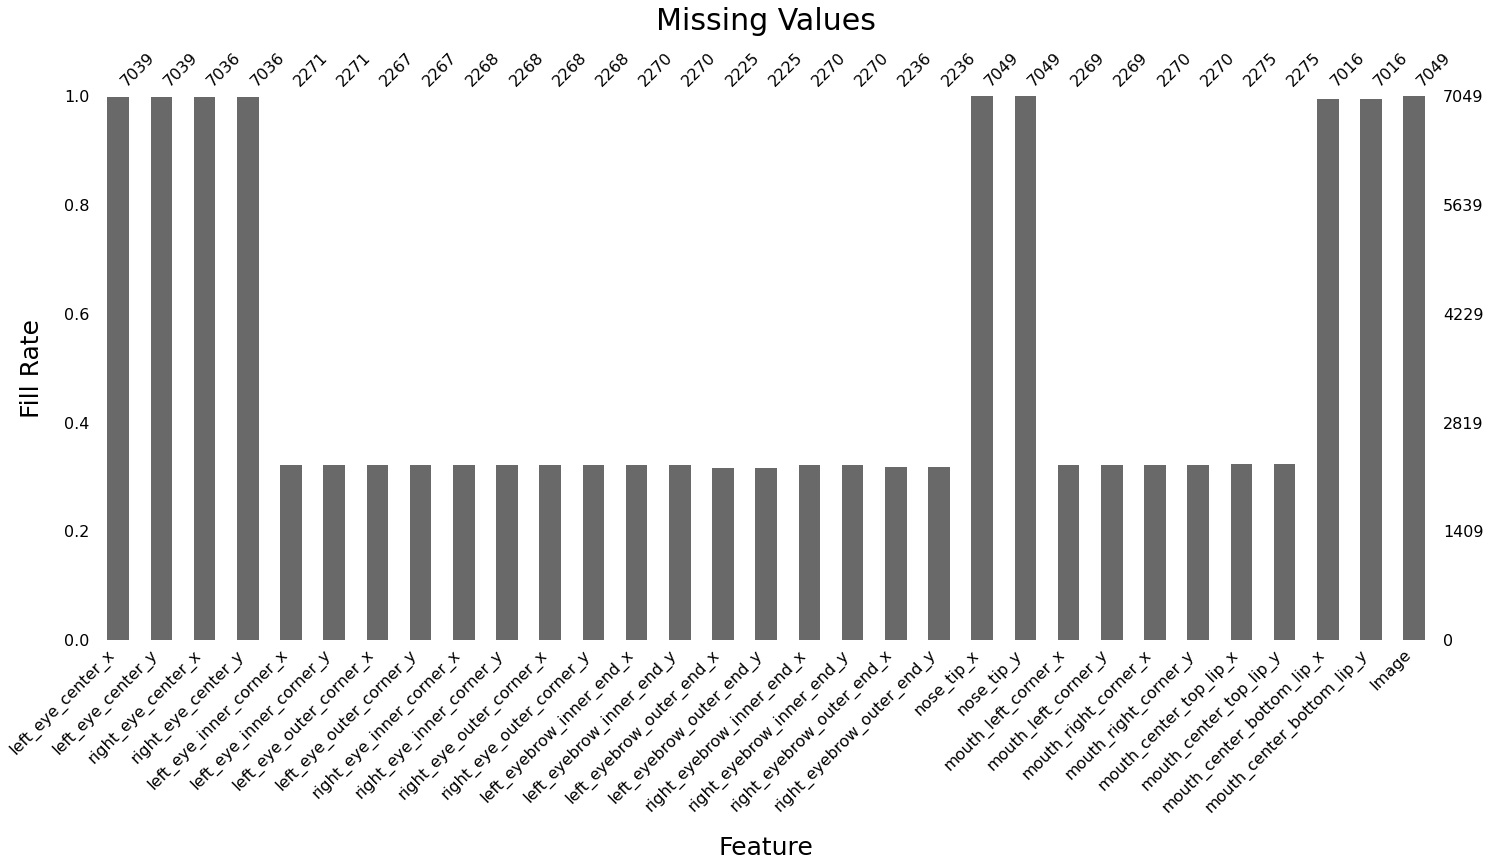

In [16]:
# view missing values
import missingno as msno
fig, ax = plt.subplots()
msno.bar(train)
ax.set_title("Missing Values", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

In [17]:
# EDA see percentage of na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

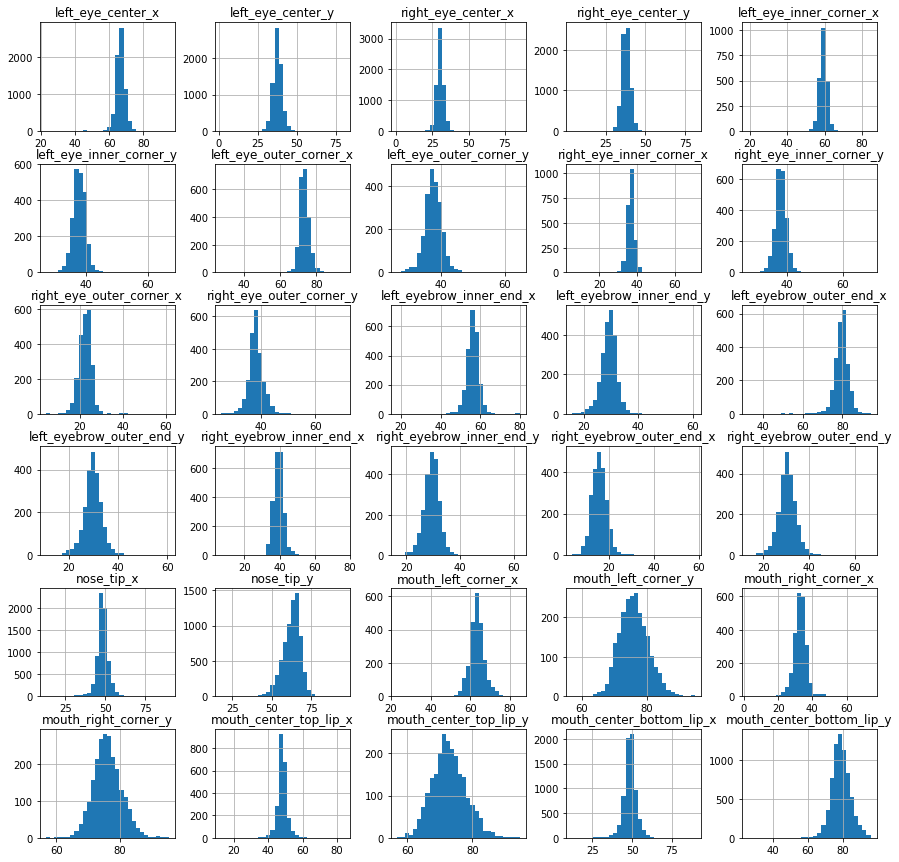

In [18]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))
plt.show()

## Let's Remove the Missing Values
- We lose 70% of the dataset when removing NAs
- We will also create a dataset with imputing the labels with forward ffill. This will get us more data, but likely less accurate labels

In [20]:
#Checking for duplicates 
train.duplicated(subset = ['Image'])

0       False
1       False
2       False
3       False
4       False
        ...  
7044     True
7045     True
7046    False
7047    False
7048     True
Length: 7049, dtype: bool

In [21]:
#drop NAs from train and split into training and dev
train_noNA_temp = train.dropna()
dev_set = train_noNA_temp[:500]
train_noNA = train_noNA_temp[500:]

#From the complete train set, drop the rows which will be included in the dev set
cond = train['Image'].isin(dev_set['Image'])
train.drop(train[cond].index, inplace = True)

#Create a ffill set based off the training data 
train_ffill = train.fillna(method='ffill')

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_labels(label_data):
    label_data = label_data.drop(['Image'], axis=1)
    label_features = []
    for idx, features in label_data.iterrows():
        label_features.append(features)
    label_features = np.array(label_features, dtype=float)
    return label_features


#Set of full data with ffill for missing labels
train_data_ffill  = load_images(train_ffill)
train_labels_ffill = load_labels(train_ffill)


#Dataset with only no NA rows
train_data_noNA  = load_images(train_noNA)
train_labels_noNA = load_labels(train_noNA)


#Dev set for testing 
dev_data = load_images(dev_set)
dev_labels = load_labels(dev_set)


#Test images for Kaggle competition 
test_images = load_images(test)


## Viusalizing the Images and Facial Keypoints

In [22]:
#Create function for showing images
def show_images(data, labels, num_examples=3):
  
  #transform data  into 2D matrix
  X2D = np.reshape(data, (-1, 96, 96))

  num = num_examples * 3
  count = 0

  #create a figure 
  fig, axes = plt.subplots(num_examples, 3, figsize = (9.6, 9.6))


  #iterate across the row of images and display one image in each of the num_examples boxes
  for n in range(num):
      ax = axes[count//num_examples, count%num_examples]
      rand = randrange(0, len(data))
      ax.imshow(X2D[rand], cmap = 'gray')
      count += 1
      for loc in range(0, len(labels[n]), 2):
          ax.plot(labels[rand][loc], labels[rand][loc+1], '*r')
      
  plt.tight_layout()
  plt.show()


### Example Images without all labeled points.

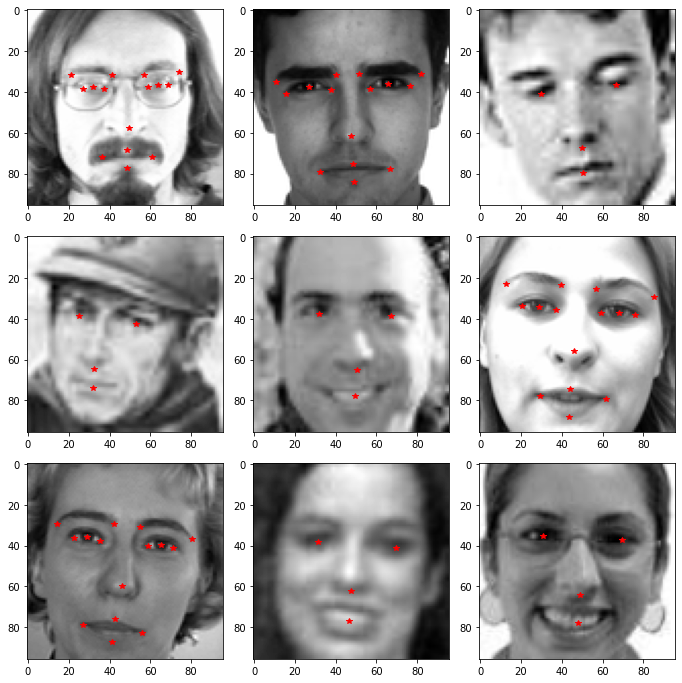

In [23]:
#explore some of the images in the training data
show_images(train_data, train_labels)

### View images with all labels.

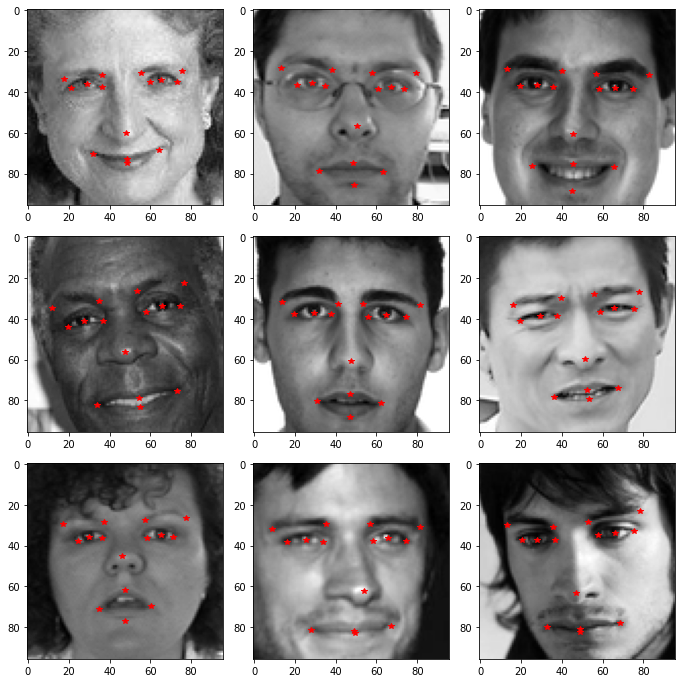

In [24]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
show_images(train_data_noNA, train_labels_noNA)

### View images with forward filled points.

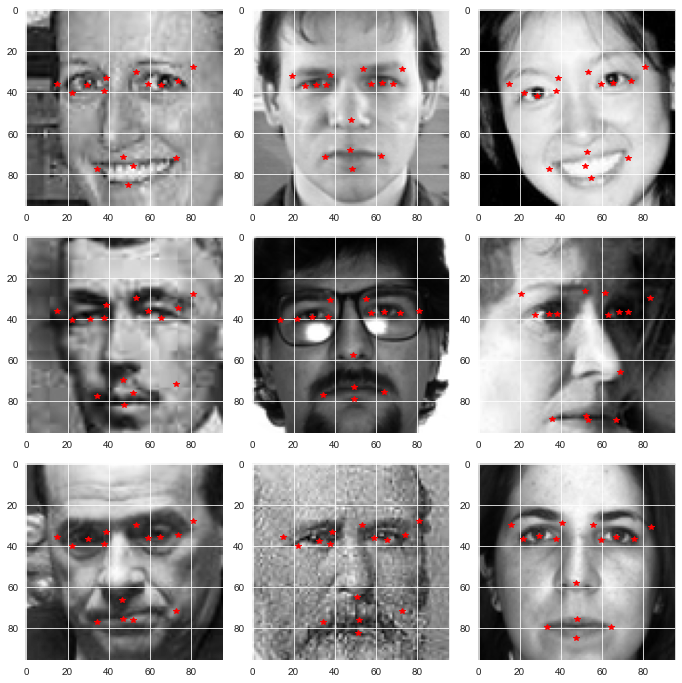

In [96]:
show_images(train_data_ffill, train_labels_ffill)

- while many of the ffill labels are close to the correct location, there is still a bit of discrepancy.

In [16]:
#take a look at removing outliers
# train_outliers  = train[((train['left_eye_inner_corner_x'] - train['left_eye_inner_corner_x'].mean()) / train['left_eye_inner_corner_x'].std()).abs() < 3]
# train_outliers = train[train.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
# train_outliers.hist(bins = 30, figsize=(15,15))
# plt.show()

#create df for noNA data to do the same analysis as above
# tempdf = pd.DataFrame(train_labels_noNA)
# tempdf.hist(bins = 30, figsize=(15,15))
# plt.show()

In [26]:
#Confirm size of the datasets
print(train_data_noNA.shape)
print(train_labels_noNA.shape)
print(train_data_ffill.shape)
print(train_labels_ffill.shape)
print(dev_data.shape)
print(dev_labels.shape)

(1640, 96, 96, 1)
(1640, 30)
(6549, 96, 96, 1)
(6549, 30)
(500, 96, 96, 1)
(500, 30)


## Augmenting the Data

In [27]:
# define image augmentation functions
def rotate_augmentation(images, keypoints, angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            rotation_matrix = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # rotate images
            for image in images:
                rotated_image = cv2.warpAffine(image, rotation_matrix, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            rotated_images_reshaped = np.reshape(rotated_images, (-1,96,96,1))
            # rotate keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0, len(rotated_keypoint), 2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            rotated_keypoints_reshaped = np.reshape(rotated_keypoints, (-1, 30))
    return rotated_images_reshaped, rotated_keypoints_reshaped

def alter_brightness(images, keypoints, increase_factor=1.2, decrease_factor=0.6):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*increase_factor, 0.0, 1.0)    # Increased brightness & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*decrease_factor, 0.0, 1.0)    # Decreased brightness & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    altered_brightness_images_reshaped = np.reshape(altered_brightness_images, (-1,96,96,1))
    altered_brightness_keypoints_reshaped = np.reshape(np.concatenate((keypoints, keypoints)), (-1, 30))
    return altered_brightness_images_reshaped, altered_brightness_keypoints_reshaped

def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            shift_matrix = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, shift_matrix, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_images_reshaped = np.reshape(shifted_images, (-1,96,96,1))
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    shifted_keypoints_reshaped = np.reshape(shifted_keypoints, (-1, 30))
    return shifted_images_reshaped, shifted_keypoints_reshaped

def add_random_noise(images, keypoints, noise_factor=0.008):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, noise_factor*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    noisy_images_reshaped = np.reshape(noisy_images, (-1,96,96,1))
    return noisy_images_reshaped, keypoints

def guassian_blur(images, keypoints, kernel=(5,5)):
    blurred_images = []
    for image in images:
        dst = cv2.GaussianBlur(image, kernel, cv2.BORDER_DEFAULT)
        blurred_image = dst.reshape(96,96,1)
        blurred_images.append(blurred_image)
    blurred_images_reshaped = np.reshape(blurred_images, (-1,96,96,1))
    return blurred_images_reshaped, keypoints

In [28]:
# rotate images and keypoints
train_data_rotated, train_labels_rotated = rotate_augmentation(train_data_noNA, train_labels_noNA, [12])

# alter brightness
train_data_brightness, train_labels_brightness = alter_brightness(
                                                        train_data_noNA,
                                                        train_labels_noNA,
                                                        increase_factor=1.2,
                                                        decrease_factor=0.6
                                                    )

# shift images and keypoints
train_data_shifted, train_labels_shifted = shift_images(train_data_noNA, train_labels_noNA, [12])

# add random noise
train_data_noise, train_labels_noise = add_random_noise(train_data_noNA, train_labels_noNA, 0.03)

# apply gaussian blur
train_data_blurred, train_labels_blurred = guassian_blur(train_data_noNA, train_labels_noNA, kernel=(5,5))

In [29]:
# merge all augmented data
train_data_aug = np.concatenate(
    (train_data_noNA, train_data_rotated, train_data_shifted, train_data_brightness, train_data_noise, train_data_blurred)
)

train_labels_aug = np.concatenate(
    (train_labels_noNA, train_labels_rotated, train_labels_shifted, train_labels_brightness, train_labels_noise, train_labels_blurred)
)

print(train_data_aug.shape)
print(train_labels_aug.shape)

(16267, 96, 96, 1)
(16267, 30)


### Doing Same Augmentation on FFill label Data

In [30]:
# rotate images and keypoints
train_data_ffill_rotated, train_labels_ffill_rotated = rotate_augmentation(train_data_ffill, train_labels_ffill, [12])

# alter brightness
train_data_ffill_brightness, train_labels_ffill_brightness = alter_brightness(
                                                        train_data_ffill,
                                                        train_labels_ffill,
                                                        increase_factor=1.2,
                                                        decrease_factor=0.6
                                                    )

# shift images and keypoints
train_data_ffill_shifted, train_labels_ffill_shifted = shift_images(train_data_ffill, train_labels_ffill, [12])

# add random noise
train_data_ffill_noise, train_labels_ffill_noise = add_random_noise(train_data_ffill, train_labels_ffill, 0.03)

# apply gaussian blur
train_data_ffill_blurred, train_labels_ffill_blurred = guassian_blur(train_data_ffill, train_labels_ffill, kernel=(5,5))

In [31]:
# merge all augmented data
train_data_ffill_aug = np.concatenate(
    (train_data_ffill, train_data_ffill_rotated, train_data_ffill_shifted, train_data_ffill_brightness, train_data_ffill_noise, train_data_ffill_blurred)
)

train_labels_ffill_aug = np.concatenate(
    (train_labels_ffill, train_labels_ffill_rotated, train_labels_ffill_shifted, train_labels_ffill_brightness, train_labels_ffill_noise, train_labels_ffill_blurred)
)

print(train_data_ffill_aug.shape)
print(train_labels_ffill_aug.shape)

(69362, 96, 96, 1)
(69362, 30)


# Modeling on the data

In [46]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

In [47]:
# shape tuples for reshaping the data for model
train_reshape = (5000, 9216)
train_noNA_reshape = (1200, 9216)
dev_reshape = (2049, 9216)
dev_noNA_reshape = (940, 9216)
label_reshape= (-1, 30)

### Baseline
- creating a perceptron model with a single hidden layer

In [48]:
# baseline model with NAs
model_base = Sequential()
model_base.add(Input(shape=(96,96,1)))
model_base.add(Dense(units=30, activation='softmax'))

model_base.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
start_time_base = time.time()
history = model_base.fit(train_data_noNA, train_labels_noNA, shuffle=True, batch_size=1, verbose=0, epochs=20)
train_time_base = time.time() - start_time_base
print ('Train time = ', train_time_base)
score_base = model_base.evaluate(dev_data, dev_labels, verbose=0) 
print('Test score:', score_base[0]) 
print('Test accuracy:', score_base[1])

ValueError: in user code:

    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/engine/training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/engine/training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 459, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/metrics.py", line 729, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/metrics.py", line 4086, in sparse_categorical_accuracy
        return tf.cast(tf.equal(y_true, y_pred), backend.floatx())

    ValueError: Dimensions must be equal, but are 30 and 96 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](IteratorGetNext:1, Cast_1)' with input shapes: [1,30], [1,96,96].


### Missing Value Records Removed

In [ ]:
# No NA model
model_NN_noNA1 = Sequential()
# model_NN_noNA1.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model_NN_noNA1.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_noNA1.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_NN_noNA1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time_noNA1 = time.time()
history = model_NN_noNA1.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=1, verbose=0, epochs=10) 
train_time_noNA1 = time.time() - start_time_noNA1
score_NN_noNA1 = model_NN_noNA1.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score_NN_noNA1[0]) 
print('Test accuracy:', score_NN_noNA1[1])

/Users/acarite/miniforge3/envs/deeplearn/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


ValueError: cannot reshape array of size 15114240 into shape (1200,9216)

Because baseline performance is higher on the missing-value-removed model, and the filled values on the missing-value records are inaccurate, we will proceed with iterating on the no-na model (or maybe we will add an additional label that specifies which records had imputed values) so the model can take that into consideration.

### Convolutional Model Baseline Attempt (FFILL)

In [49]:
model_CNN_ffill1 = Sequential() 
model_CNN_ffill1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_ffill1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_ffill1.add(Dropout(0.5))
model_CNN_ffill1.add(Flatten())
model_CNN_ffill1.add(Dense(96))
model_CNN_ffill1.add(BatchNormalization())
model_CNN_ffill1.add(Activation('relu'))
model_CNN_ffill1.add(Dense(30))
 

# model_CNN_ffill1.summary()
start_time_CNN_ffill1 = time.time()
model_CNN_ffill1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_CNN_ffill1 = model_CNN_ffill1.fit(train_data_ffill, train_labels_ffill, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_CNN_ffill1 = time.time() - start_time_CNN_ffill1
score_CNN_ffill1 = model_CNN_ffill1.evaluate(dev_data, dev_labels, verbose=0)
print('Test score:', score_CNN_ffill1[0]) 
print('Test accuracy:', score_CNN_ffill1[1])



Epoch 1/100
103/103 [==============================] - 24s 226ms/step - loss: nan - accuracy: 0.0081 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
103/103 [==============================] - 23s 223ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
103/103 [==============================] - 23s 224ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
103/103 [==============================] - 23s 224ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0000e+00
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
103/103 [==============================] - 23s 224ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
103/103 [================

Text(0.5, 0.98, 'Model Metrics')

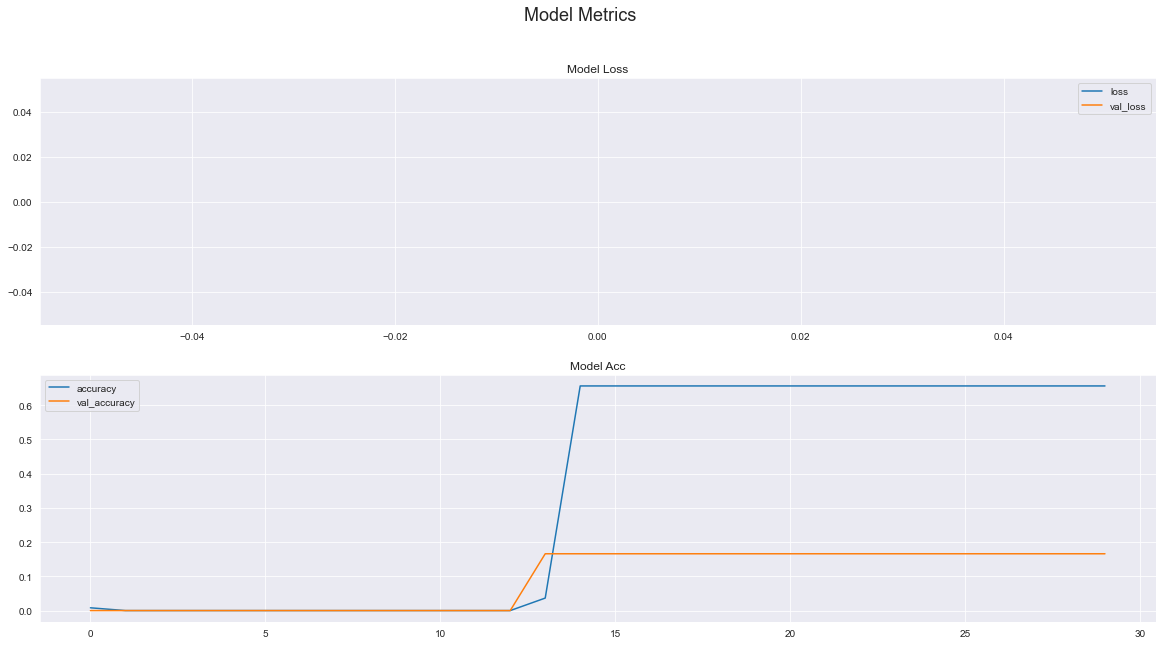

In [50]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_ffill1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Same CNN as before, but training with the noNA dataset

In [51]:
model_CNN_noNA1 = Sequential() 
model_CNN_noNA1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_noNA1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_noNA1.add(Dropout(0.2))
model_CNN_noNA1.add(Flatten())
model_CNN_noNA1.add(Dense(96))
model_CNN_noNA1.add(BatchNormalization())
model_CNN_noNA1.add(Activation('relu'))
model_CNN_noNA1.add(Dense(30))
 

model_CNN_noNA1.summary()

start_time_CNN_noNA1 = time.time()
model_CNN_noNA1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_CNN_noNA1 = model_CNN_noNA1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_CNN_noNA1 = time.time() - start_time_CNN_noNA1
score_CNN_noNA1 = model_CNN_noNA1.evaluate(dev_data, dev_labels)
print('Test score:', score_CNN_noNA1[0]) 
print('Test accuracy:', score_CNN_noNA1[1])


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 47, 47, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 141376)            0         
                                                                 
 dense_20 (Dense)            (None, 96)                13572192  
                                                                 
 batch_normalization_6 (Batc  (None, 96)               384       
 hNormalization)                                     

Text(0.5, 0.98, 'Model Metrics')

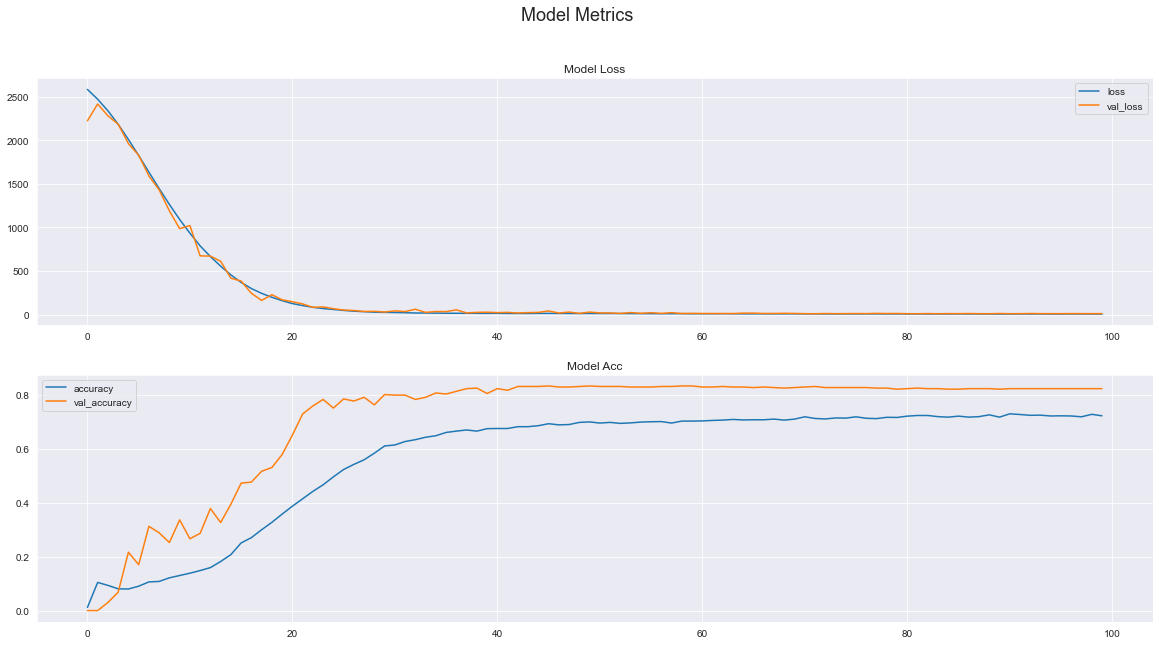

In [52]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_noNA1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Transfer learning with Resnet50: CNN with Pre-trained Resnet and one dense layer

In [53]:
model_resnet_noNA_D1 = Sequential() 
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_D1.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_D1.add(pretrained_model)
model_resnet_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_D1.add(Dropout(0.1))
model_resnet_noNA_D1.add(Flatten())
model_resnet_noNA_D1.add(Dense(30))
model_resnet_noNA_D1.summary()

model_resnet_noNA_D1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 1, 1, 2048)        0         
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                     

In [54]:
start_time_resnet_noNA_D1 = time.time()
model_resnet_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_resnet_noNA_D1 = model_resnet_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_resnet_noNA_D1 = time.time() - start_time_resnet_noNA_D1
score_resnet_noNA_D1 = model_resnet_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D1[0]) 
print('Test accuracy:', score_resnet_noNA_D1[1])


Epoch 1/100
26/26 [==============================] - 11s 302ms/step - loss: 293.3661 - accuracy: 0.4799 - val_loss: 111.9755 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 7s 255ms/step - loss: 11.8715 - accuracy: 0.5963 - val_loss: 178.7583 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 7s 253ms/step - loss: 8.9276 - accuracy: 0.6305 - val_loss: 294.6587 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 7s 253ms/step - loss: 7.4232 - accuracy: 0.6530 - val_loss: 200.4742 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 6s 247ms/step - loss: 6.1469 - accuracy: 0.6628 - val_loss: 130.8353 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - ETA: 0s - loss: 5.3835 - accuracy: 0.6848
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
26/26 [============================

Text(0.5, 0.98, 'Model Metrics')

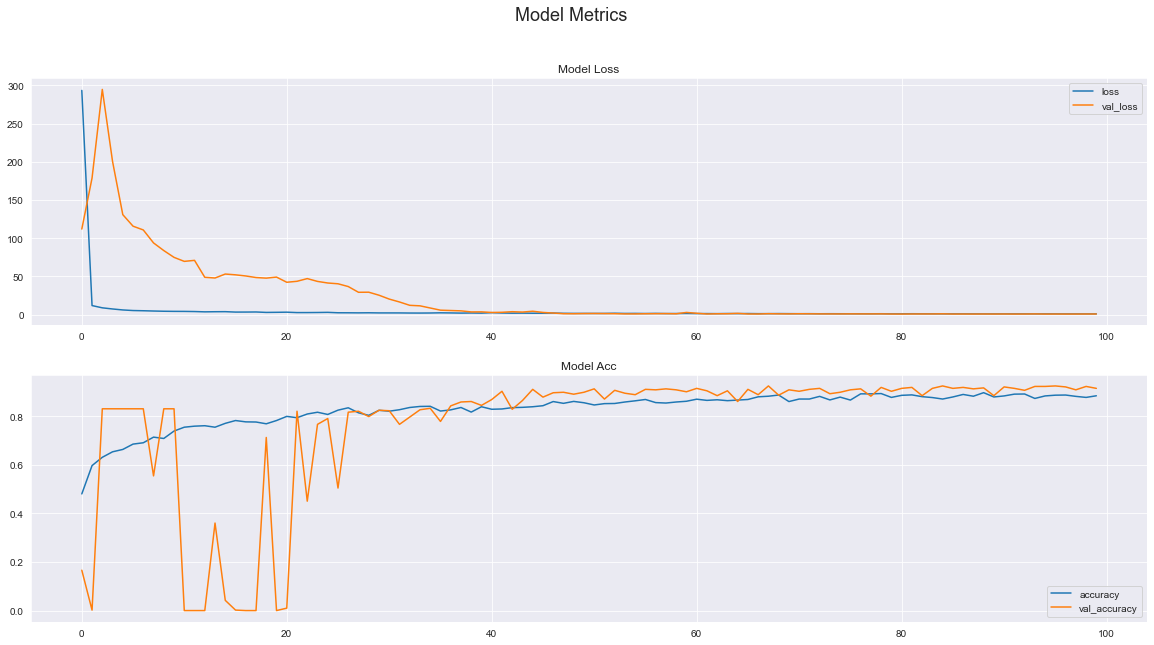

In [55]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Resnet pretrained with two dense layers

In [56]:
model_resnet_noNA_D2 = Sequential() 
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_noNA_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_D2.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_D2.add(pretrained_model)
model_resnet_noNA_D2.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_D2.add(Dropout(0.1))
model_resnet_noNA_D2.add(Flatten())
model_resnet_noNA_D2.add(Dense(96))
model_resnet_noNA_D2.add(Dense(30))


model_resnet_noNA_D2.summary()



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 1, 1, 2048)        0         
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                     

In [57]:
start_time_resnet_noNA_D2 = time.time()
model_resnet_noNA_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_resnet_noNA_D2 = model_resnet_noNA_D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_resnet_noNA_D2 = time.time() - start_time_resnet_noNA_D2
score_resnet_noNA_D2 = model_resnet_noNA_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D2[0]) 
print('Test accuracy:', score_resnet_noNA_D2[1])

Epoch 1/100
26/26 [==============================] - 12s 324ms/step - loss: 282.9068 - accuracy: 0.4579 - val_loss: 900.7545 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 7s 255ms/step - loss: 11.9150 - accuracy: 0.6323 - val_loss: 1019.2364 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 7s 254ms/step - loss: 8.1675 - accuracy: 0.6396 - val_loss: 529.7880 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 6s 248ms/step - loss: 7.1799 - accuracy: 0.6756 - val_loss: 343.0074 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 7s 251ms/step - loss: 7.0026 - accuracy: 0.6787 - val_loss: 272.1737 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 7s 252ms/step - loss: 5.6766 - accuracy: 0.7293 - val_loss: 162.7811 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 7/100
26/26 [============================

Text(0.5, 0.98, 'Model Metrics')

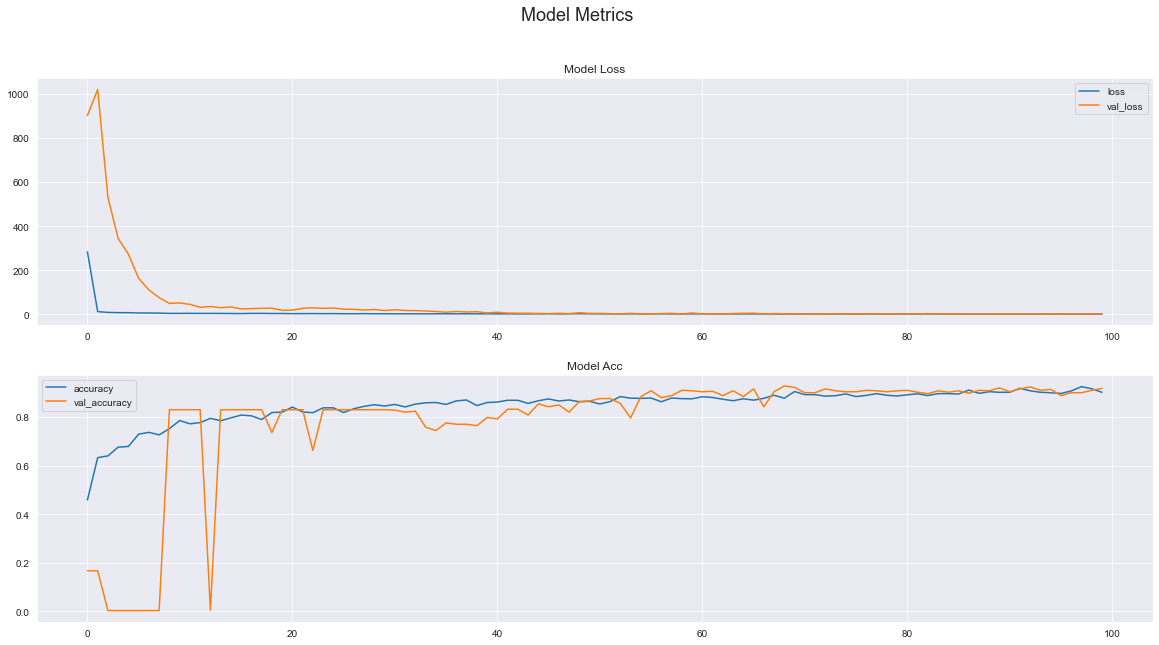

In [58]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### ResnetV2 With lots of Dense Layers


In [59]:
model_resnet_noNA_C1D4 = Sequential() 
pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_noNA_C1D4.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.2))
model_resnet_noNA_C1D4.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 64)))
model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_C1D4.add(pretrained_model)
model_resnet_noNA_C1D4.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_C1D4.add(Dropout(0.1))
model_resnet_noNA_C1D4.add(Flatten())
model_resnet_noNA_C1D4.add(Dense(1024))
model_resnet_noNA_C1D4.add(Dense(512))
model_resnet_noNA_C1D4.add(Dense(96))
model_resnet_noNA_C1D4.add(Dense(30))


model_resnet_noNA_C1D4.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 64)        320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 96, 96, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 3)         195       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                     

In [60]:
start_time_resnet_noNA_C1D4 = time.time()
model_resnet_noNA_C1D4.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_resnet_noNA_C1D4 = time.time() - start_time_resnet_noNA_C1D4
score_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_C1D4[0]) 
print('Test accuracy:', score_resnet_noNA_C1D4[1])

Epoch 1/100
26/26 [==============================] - 13s 353ms/step - loss: 451.4625 - accuracy: 0.3079 - val_loss: 19744.5254 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 7s 268ms/step - loss: 31.5877 - accuracy: 0.5988 - val_loss: 5103.9644 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 7s 259ms/step - loss: 17.4653 - accuracy: 0.6457 - val_loss: 337.4629 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 7s 255ms/step - loss: 14.3967 - accuracy: 0.6348 - val_loss: 776.6311 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 7s 255ms/step - loss: 13.9570 - accuracy: 0.6482 - val_loss: 449.4507 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 7s 254ms/step - loss: 12.1771 - accuracy: 0.6402 - val_loss: 287.7776 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [======================

Text(0.5, 0.98, 'Model Metrics')

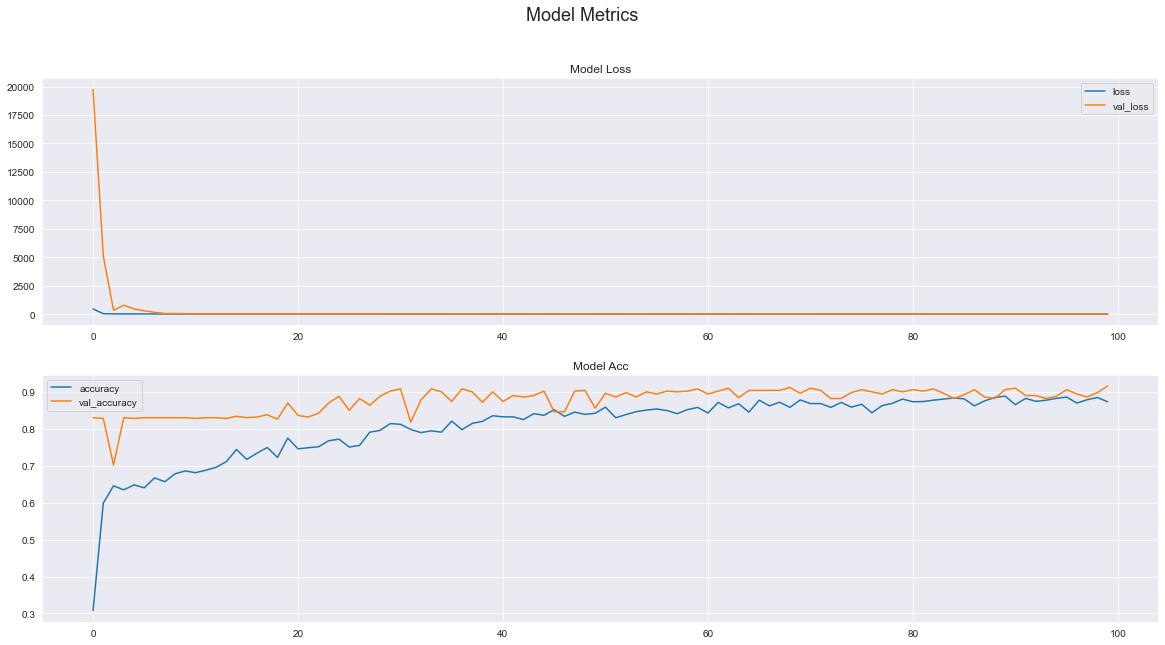

In [61]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_C1D4.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Efficient Net (1 Dense Layer)

In [62]:
model_effnetB7_noNA_D1 = Sequential() 
pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

model_effnetB7_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetB7_noNA_D1.add(LeakyReLU(alpha=0.1))
model_effnetB7_noNA_D1.add(pretrained_model)
model_effnetB7_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetB7_noNA_D1.add(Dropout(0.1))
model_effnetB7_noNA_D1.add(Flatten())
model_effnetB7_noNA_D1.add(Dense(30))


model_effnetB7_noNA_D1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 1, 1, 2560)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 1, 1, 2560)        0         
                                                                 
 flatten_10 (Flatten)        (None, 2560)              0         
                                                     

In [63]:
start_time_effnetB7_noNA_D1 = time.time()
model_effnetB7_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_effnetB7_noNA_D1 = time.time() - start_time_effnetB7_noNA_D1
score_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_noNA_D1[0]) 
print('Test accuracy:', score_effnetB7_noNA_D1[1])

Epoch 1/100
26/26 [==============================] - 92s 2s/step - loss: 426.6741 - accuracy: 0.5610 - val_loss: 2980.8513 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 33s 1s/step - loss: 18.5684 - accuracy: 0.6537 - val_loss: 555.7536 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 30s 1s/step - loss: 14.4759 - accuracy: 0.6628 - val_loss: 217.6435 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 31s 1s/step - loss: 12.2700 - accuracy: 0.6652 - val_loss: 70.4587 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 30s 1s/step - loss: 10.3896 - accuracy: 0.6561 - val_loss: 44.6175 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 30s 1s/step - loss: 9.5241 - accuracy: 0.6524 - val_loss: 24.3709 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [==============================] -

Text(0.5, 0.98, 'Model Metrics')

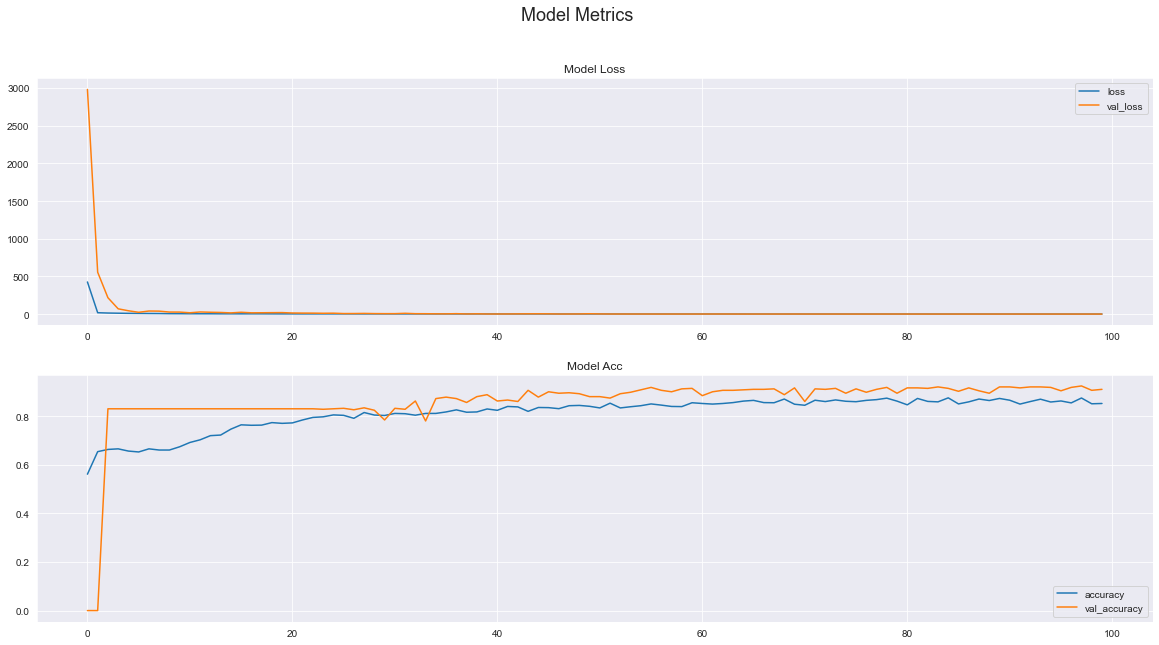

In [64]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### EfficientNet_v2B3 try number 2 (two conv, two dense, using Efficientnetv2_B3)


In [65]:
model_effnetV2B3_noNA_C2D2 = Sequential() 
pretrained_model = EfficientNetV2B3(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

model_effnetV2B3_noNA_C2D2.add(Conv2D(24, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.2))
model_effnetV2B3_noNA_C2D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 24)))
model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.1))
model_effnetV2B3_noNA_C2D2.add(pretrained_model)
model_effnetV2B3_noNA_C2D2.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetV2B3_noNA_C2D2.add(Dropout(0.1))
model_effnetV2B3_noNA_C2D2.add(Flatten())
model_effnetV2B3_noNA_C2D2.add(Dense(90))
model_effnetV2B3_noNA_C2D2.add(Dense(30))



model_effnetV2B3_noNA_C2D2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 96, 96, 24)        120       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 96, 96, 24)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 3)         75        
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 1, 1, 1536)       0         
 g2D)                                                

In [66]:
start_time_effnetV2B3_noNA_C2D2 = time.time()
model_effnetV2B3_noNA_C2D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_effnetV2B3_noNA_C2D2 = time.time() - start_time_effnetV2B3_noNA_C2D2
score_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetV2B3_noNA_C2D2[0]) 
print('Test accuracy:', score_effnetV2B3_noNA_C2D2[1])

Epoch 1/100
26/26 [==============================] - 50s 1s/step - loss: 476.6443 - accuracy: 0.2744 - val_loss: 1080.5861 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 9s 342ms/step - loss: 14.6215 - accuracy: 0.6043 - val_loss: 11.3735 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 8s 323ms/step - loss: 10.9488 - accuracy: 0.6409 - val_loss: 10.8682 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 8s 314ms/step - loss: 9.9068 - accuracy: 0.6598 - val_loss: 12.4655 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 7s 286ms/step - loss: 8.2190 - accuracy: 0.6463 - val_loss: 6.1728 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 8s 306ms/step - loss: 6.7179 - accuracy: 0.6652 - val_loss: 14.2521 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 8s

Text(0.5, 0.98, 'Model Metrics')

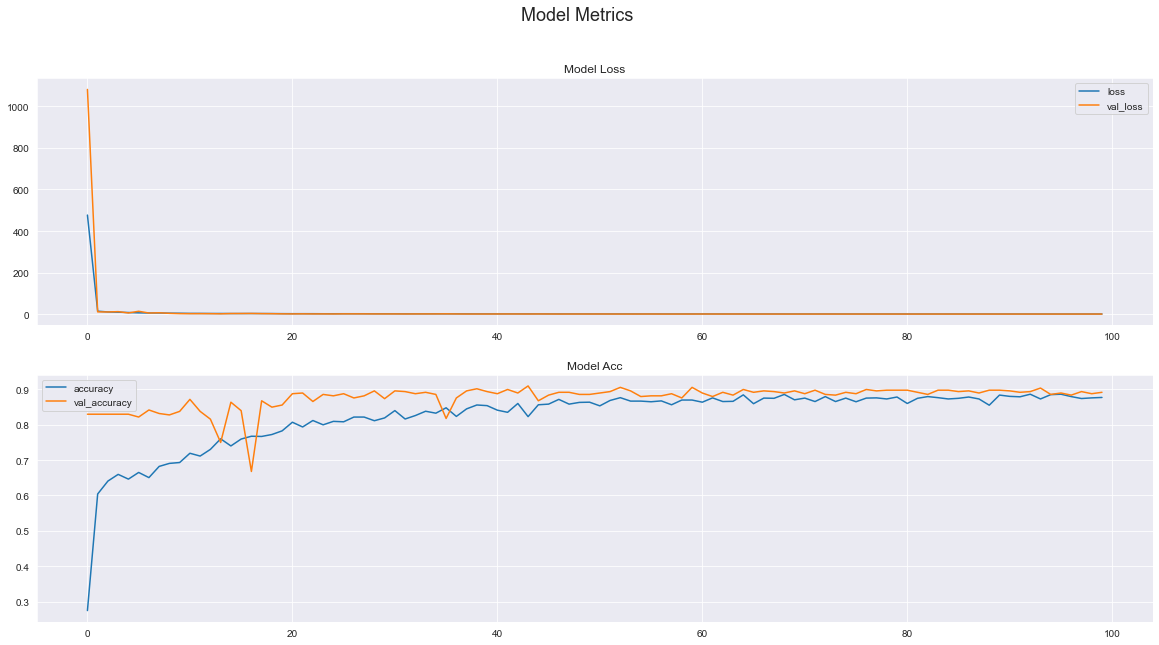

In [67]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetV2B3_noNA_C2D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Resnet50 with Augmented Data - Transfer Learning

In [68]:
model_resnet_aug_D2 = Sequential() 
pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_aug_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same',  input_shape=(96, 96, 1)))
model_resnet_aug_D2.add(LeakyReLU(alpha=0.1))
model_resnet_aug_D2.add(pretrained_model)
model_resnet_aug_D2.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_aug_D2.add(Dropout(0.1))
model_resnet_aug_D2.add(Flatten())
model_resnet_aug_D2.add(Dense(96))
model_resnet_aug_D2.add(Dense(30))


model_resnet_aug_D2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 1, 1, 2048)        0         
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                     

In [69]:
start_time_resnet_aug_D2 = time.time()
model_resnet_aug_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_resnet_aug_D2 = model_resnet_aug_D2.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
end_time_resnet_aug_D2 = time.time() - start_time_resnet_aug_D2
score_resnet_aug_D2 = model_resnet_aug_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_aug_D2[0]) 
print('Test accuracy:', score_resnet_aug_D2[1])

Epoch 1/100
255/255 [==============================] - 68s 237ms/step - loss: 56.9972 - accuracy: 0.6273 - val_loss: 19.4662 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - 54s 212ms/step - loss: 7.0639 - accuracy: 0.7177 - val_loss: 3.9829 - val_accuracy: 0.8340 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - 54s 210ms/step - loss: 5.4733 - accuracy: 0.7597 - val_loss: 3.2333 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 4/100
255/255 [==============================] - 54s 210ms/step - loss: 4.5341 - accuracy: 0.7883 - val_loss: 1.7849 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 5/100
255/255 [==============================] - 53s 209ms/step - loss: 3.9743 - accuracy: 0.8088 - val_loss: 4.8075 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 6/100
255/255 [==============================] - 53s 210ms/step - loss: 3.9465 - accuracy: 0.8164 - val_loss: 2.5195 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 7/100
255/255 [=======================

Text(0.5, 0.98, 'Model Metrics')

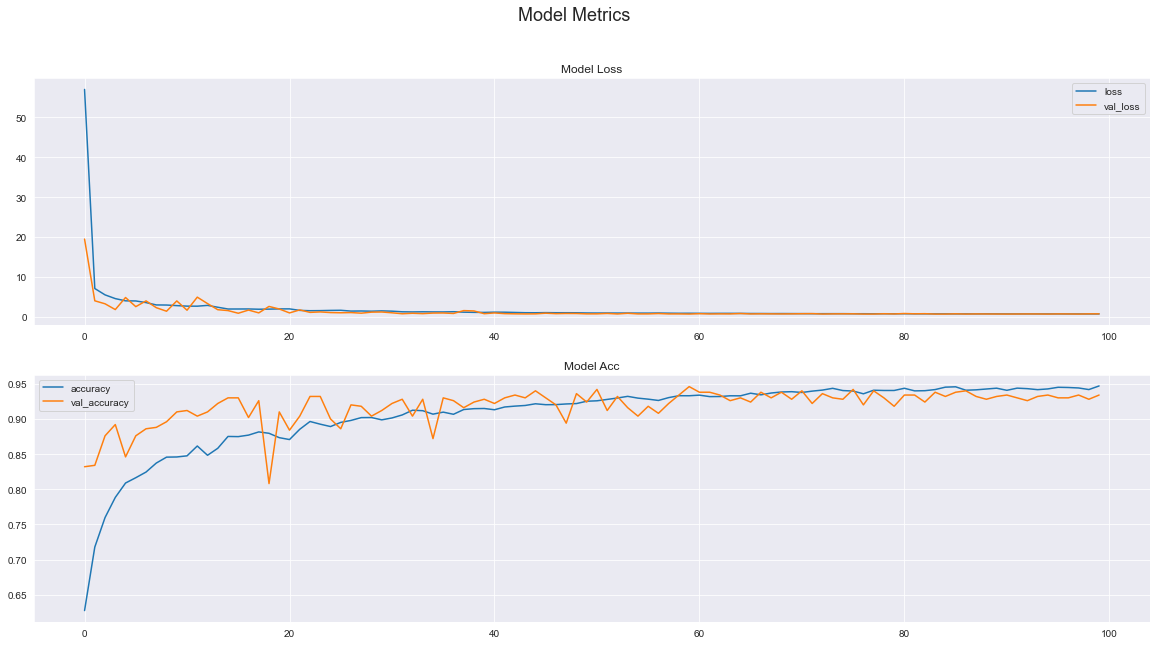

In [70]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_aug_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Efficientnet with Augmented data 

In [71]:
model_effnetB7_aug_D1 = Sequential() 
pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

model_effnetB7_aug_D1.add(Conv2D(3, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetB7_aug_D1.add(LeakyReLU(alpha=0.1))
model_effnetB7_aug_D1.add(pretrained_model)
model_effnetB7_aug_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetB7_aug_D1.add(Dropout(0.1))
model_effnetB7_aug_D1.add(Flatten())
model_effnetB7_aug_D1.add(Dense(30))


model_effnetB7_aug_D1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 3)         15        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 1, 1, 2560)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 1, 1, 2560)        0         
                                                                 
 flatten_13 (Flatten)        (None, 2560)              0         
                                                     

In [72]:
start_time_effnetB7_aug_D1 = time.time()
model_effnetB7_aug_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_effnetB7_aug_D1 = model_effnetB7_aug_D1.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=80, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
Train_time_effnetB7_aug_D1 = time.time() - start_time_effnetB7_aug_D1
score_effnetB7_aug_D1 = model_effnetB7_aug_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_aug_D1[0])
print('Test accuracy:', score_effnetB7_aug_D1[1])

Epoch 1/80
255/255 [==============================] - 406s 1s/step - loss: 50.8347 - accuracy: 0.6427 - val_loss: 65.6982 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/80
255/255 [==============================] - 273s 1s/step - loss: 6.7729 - accuracy: 0.7274 - val_loss: 28.4117 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/80
255/255 [==============================] - 273s 1s/step - loss: 4.8948 - accuracy: 0.7745 - val_loss: 5.1608 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 4/80
255/255 [==============================] - 271s 1s/step - loss: 3.9543 - accuracy: 0.8020 - val_loss: 3.0330 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 5/80
255/255 [==============================] - 271s 1s/step - loss: 3.4315 - accuracy: 0.8141 - val_loss: 2.8708 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 6/80
255/255 [==============================] - 271s 1s/step - loss: 3.1786 - accuracy: 0.8284 - val_loss: 2.1111 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 7/80
255/255 [==============================] - 269s 1s

In [73]:
#finetune
pretrained_model.trainable = True
model_effnetB7_aug_D1.summary()

model_effnetB7_aug_D1.compile(
    optimizer=Adam(1e-5),
    loss='mean_squared_error',
    metrics=['accuracy']
)

history_effnetB7_aug_D1 = model_effnetB7_aug_D1.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=20, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_resnet_aug_D1 = model_effnetB7_aug_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_aug_D1[0]) 
print('Test accuracy:', score_resnet_aug_D1[1])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 3)         15        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 1, 1, 2560)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 1, 1, 2560)        0         
                                                                 
 flatten_13 (Flatten)        (None, 2560)              0         
                                                     

Text(0.5, 0.98, 'Model Metrics')

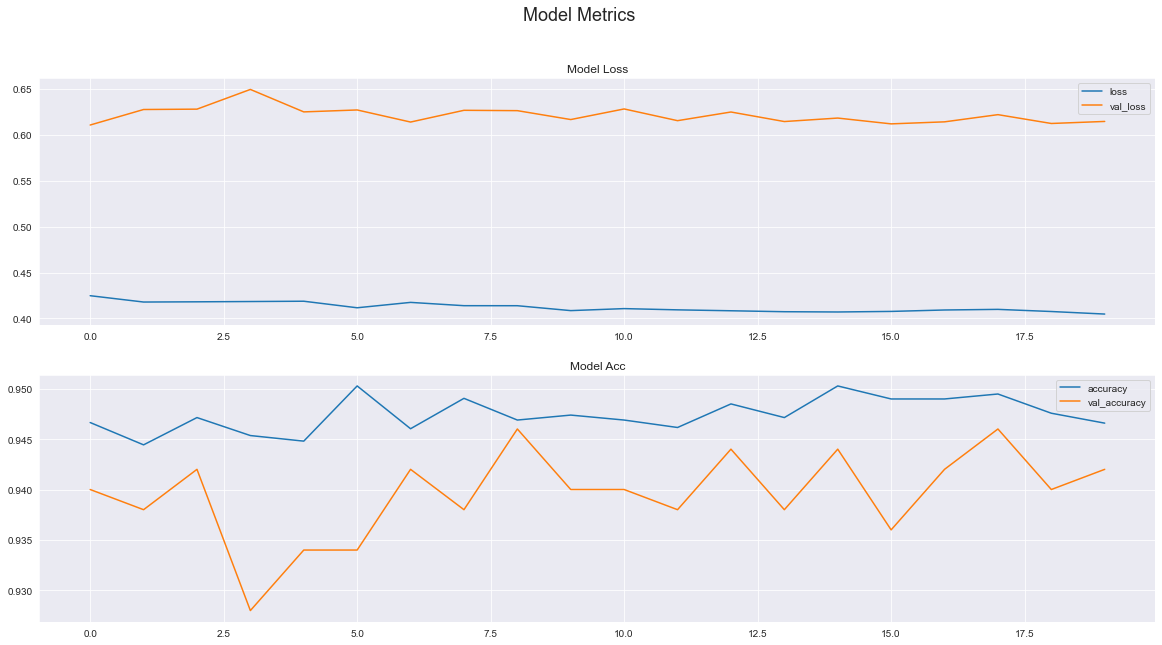

In [74]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_aug_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

## Creating Submission

In [128]:
id_lookup = pd.read_csv('IdLookupTable.csv')

ImageId = list(id_lookup['ImageId']-1)
RowId = list(id_lookup['RowId'])
FeatureName = list(id_lookup['FeatureName'])
feature_list = []
for feature in FeatureName:
    feature_list.append(FeatureName.index(feature))



In [129]:
def submit(model, test_data, model_name):
    #RowId,ImageId,FeatureName,Location
    #Make Predictions 
    y_pred = model.predict(test_data)

    predictions = []
    for x,y in zip(ImageId, feature_list):
        predictions.append(y_pred[x][y])
        
    row_ids = pd.Series(RowId, name = 'RowId')
    locations = pd.Series(predictions, name = 'Location')
    
    #post processing step 
    locations = locations.clip(0.0,96.0)
    submission_result = pd.concat([row_ids,locations],axis = 1)
    submission_result.to_csv('eff_net_2', index = False)
